# XPINN - Extended Physics-Informed Neural Networks

## Método C: División del Dominio Temporal

En lugar de usar una sola red neuronal para todo el intervalo temporal, este enfoque **divide el tiempo en subdominios** y entrena **una red independiente por cada subdominio**.

### Concepto Principal

```
Dominio temporal: [0, 2π]

┌─────────────┬─────────────┬─────────────┬─────────────┐
│  Subdominio 1 │  Subdominio 2 │  Subdominio 3 │  Subdominio 4 │
│    [0, π/2]   │  [π/2, π]    │   [π, 3π/2]  │  [3π/2, 2π]  │
│     Red NN₁   │    Red NN₂    │    Red NN₃   │    Red NN₄   │
└─────────────┴─────────────┴─────────────┴─────────────┘
```

### Condiciones de Conexión

1. **Continuidad en las interfaces**: ψ₁(x, t_interface) = ψ₂(x, t_interface)
2. **Continuidad de derivadas**: ∂ψ₁/∂t(x, t_interface) = ∂ψ₂/∂t(x, t_interface)
3. **Periodicidad**: ψ₄(x, 2π) = ψ₁(x, 0)

### Función de Pérdida por Subdominio

$$\mathcal{L}_i = \mathcal{L}_{IC}^i + \mathcal{L}_{BC}^i + \mathcal{L}_{PDE}^i + \mathcal{L}_{interface}^i$$

### Ventajas

- ✅ **Especialización**: Cada red se enfoca en un tramo temporal específico
- ✅ **Paralelización**: Las redes pueden entrenarse en paralelo
- ✅ **Mejor convergencia**: Problemas más simples por subdominio
- ✅ **Escalabilidad**: Fácil añadir más subdominios

### Referencia

Basado en: Jagtap & Karniadakis (2020) - "Extended Physics-Informed Neural Networks (XPINNs)"
https://ceur-ws.org/Vol-2964/article_60.pdf

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import time
import json
from scipy.interpolate import griddata
from pyDOE import lhs

import torch
import torch.nn as nn
import torch.optim as optim
from typing import List, Tuple, Dict

# Set random seeds for reproducibility
torch.manual_seed(1234)
np.random.seed(1234)

# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\033[91mUsing device: {device}\033[0m")

if torch.cuda.is_available():
    torch.backends.cudnn.benchmark = True
    print("cuDNN benchmark enabled for better performance")

Using device: cuda
cuDNN benchmark enabled for better performance


In [2]:
def nls_solution_N2_fast():
    """
    Solución exacta de la ecuación NLS para N=2 (2 solitones)
    Extendida a t ∈ [0, 2π] para verificar periodicidad
    """
    # Dominio extendido
    x = np.linspace(-5, 5, 256)
    t = np.linspace(0, 2*np.pi, 201)
    
    X, T = np.meshgrid(x, t, indexing='ij')
    
    # Solución vectorizada para N=2 (Satsuma-Yajima)
    numerator = 4 * (np.cosh(3*X) + 3 * np.exp(4j*T) * np.cosh(X)) * np.exp(0.5j*T)
    denominator = np.cosh(4*X) + 4 * np.cosh(2*X) + 3 * np.cos(4*T)
    
    psi = numerator / denominator
    
    return x, t, psi

# Generar datos de entrenamiento
print("Generando solución exacta...")
x, t, psi = nls_solution_N2_fast()

# Extraer partes real e imaginaria
Exact_u = np.real(psi)
Exact_v = np.imag(psi)
Exact_h = np.abs(psi)

print(f"\nDominio espacial: x ∈ [{x.min():.1f}, {x.max():.1f}]")
print(f"Dominio temporal: t ∈ [{t.min():.4f}, {t.max():.4f}]")
print(f"Forma de la solución: {psi.shape}")
print(f"Puntos en x: {len(x)}, Puntos en t: {len(t)}")

Generando solución exacta...

Dominio espacial: x ∈ [-5.0, 5.0]
Dominio temporal: t ∈ [0.0000, 6.2832]
Forma de la solución: (256, 201)
Puntos en x: 256, Puntos en t: 201


In [3]:
class NeuralNetwork(nn.Module):
    """
    Red neuronal estándar para cada subdominio
    """
    def __init__(self, layers):
        super(NeuralNetwork, self).__init__()
        
        self.depth = len(layers) - 1
        self.activation = nn.Tanh()
        
        layer_list = []
        for i in range(self.depth):
            layer_list.append(nn.Linear(layers[i], layers[i+1]))
            nn.init.xavier_normal_(layer_list[i].weight)
            nn.init.zeros_(layer_list[i].bias)
            
        self.layers = nn.ModuleList(layer_list)
    
    def forward(self, x):
        for i in range(self.depth - 1):
            x = self.activation(self.layers[i](x))
        
        # Última capa sin activación
        x = self.layers[-1](x)
        return x

In [4]:
class SubdomainPINN:
    """
    PINN para un subdominio temporal específico [t_start, t_end]
    """
    def __init__(self, subdomain_id, t_start, t_end, layers, lb, ub):
        self.subdomain_id = subdomain_id
        self.t_start = t_start
        self.t_end = t_end
        
        # Límites del subdominio
        self.lb = torch.tensor([lb[0], t_start], dtype=torch.float32).to(device)
        self.ub = torch.tensor([ub[0], t_end], dtype=torch.float32).to(device)
        
        # Red neuronal para este subdominio
        self.model = NeuralNetwork(layers).to(device)
        
        print(f"Subdominio {subdomain_id}: t ∈ [{t_start:.4f}, {t_end:.4f}]")
    
    def net_uv(self, x, t):
        """
        Predicción de u y v
        """
        # Normalizar entradas a [-1, 1] dentro del subdominio
        X = torch.cat([x, t], dim=1)
        X_normalized = 2.0 * (X - self.lb) / (self.ub - self.lb) - 1.0
        
        # Forward pass
        uv = self.model(X_normalized)
        u, v = uv[:, 0:1], uv[:, 1:2]
        
        return u, v
    
    def net_f_uv(self, x, t):
        """
        Residuales de la ecuación NLS
        """
        x = x.clone().detach().requires_grad_(True)
        t = t.clone().detach().requires_grad_(True)
        
        u, v = self.net_uv(x, t)
        
        # Derivadas de u
        u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u),
                                 retain_graph=True, create_graph=True)[0]
        u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u),
                                 retain_graph=True, create_graph=True)[0]
        u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x),
                                  retain_graph=True, create_graph=True)[0]
        
        # Derivadas de v
        v_t = torch.autograd.grad(v, t, grad_outputs=torch.ones_like(v),
                                 retain_graph=True, create_graph=True)[0]
        v_x = torch.autograd.grad(v, x, grad_outputs=torch.ones_like(v),
                                 retain_graph=True, create_graph=True)[0]
        v_xx = torch.autograd.grad(v_x, x, grad_outputs=torch.ones_like(v_x),
                                  retain_graph=True, create_graph=True)[0]
        
        # Ecuación NLS
        f_u = u_t + 0.5*v_xx + (u**2 + v**2)*v
        f_v = v_t - 0.5*u_xx - (u**2 + v**2)*u
        
        return f_u, f_v

In [5]:
class XPINN_Manager:
    """
    Gestor de Extended PINN que coordina múltiples subdominios temporales
    """
    def __init__(self, n_subdomains, x0, u0, v0, X_f_list, layers, lb, ub, T_period=2*np.pi,
                 lambda_interface=10.0, lambda_periodic=10.0):
        """
        Args:
            n_subdomains: Número de subdominios temporales
            x0: Puntos espaciales de condición inicial
            u0, v0: Valores iniciales de u y v
            X_f_list: Lista de puntos de colocación por subdominio
            layers: Arquitectura de la red
            lb, ub: Límites del dominio completo
            T_period: Periodo temporal
            lambda_interface: Peso de la pérdida de interfaz
            lambda_periodic: Peso de la pérdida periódica
        """
        self.n_subdomains = n_subdomains
        self.T_period = T_period
        self.lambda_interface = lambda_interface
        self.lambda_periodic = lambda_periodic
        
        # Dividir el dominio temporal
        self.t_interfaces = np.linspace(0, T_period, n_subdomains + 1)
        
        print(f"\n{'='*60}")
        print(f"XPINN - Extended Physics-Informed Neural Networks")
        print(f"{'='*60}")
        print(f"Número de subdominios: {n_subdomains}")
        print(f"Periodo temporal: T = {T_period:.4f}")
        print(f"\nInterfaces temporales:")
        for i in range(len(self.t_interfaces)):
            print(f"  t_{i} = {self.t_interfaces[i]:.4f}")
        print(f"{'='*60}\n")
        
        # Crear subdominios
        self.subdomains = []
        for i in range(n_subdomains):
            subdomain = SubdomainPINN(
                subdomain_id=i,
                t_start=self.t_interfaces[i],
                t_end=self.t_interfaces[i+1],
                layers=layers,
                lb=lb,
                ub=ub
            )
            self.subdomains.append(subdomain)
        
        # Condiciones iniciales (solo para el primer subdominio)
        self.x0 = torch.tensor(x0, dtype=torch.float32).to(device)
        self.t0 = torch.tensor(np.zeros_like(x0), dtype=torch.float32).to(device)
        self.u0 = torch.tensor(u0, dtype=torch.float32).to(device)
        self.v0 = torch.tensor(v0, dtype=torch.float32).to(device)
        
        # Condiciones de frontera espaciales
        self.lb_global = torch.tensor(lb, dtype=torch.float32).to(device)
        self.ub_global = torch.tensor(ub, dtype=torch.float32).to(device)
        
        # Puntos de colocación por subdominio
        self.X_f_list = []
        for i, X_f in enumerate(X_f_list):
            x_f = torch.tensor(X_f[:, 0:1], dtype=torch.float32).to(device)
            t_f = torch.tensor(X_f[:, 1:2], dtype=torch.float32).to(device)
            self.X_f_list.append((x_f, t_f))
        
        # Puntos de interfaz para continuidad
        self.interface_points = self._generate_interface_points(x0)
        
        # Optimizadores (uno por subdominio)
        self.optimizers = []
        for subdomain in self.subdomains:
            optimizer = optim.Adam(subdomain.model.parameters(), lr=0.001)
            self.optimizers.append(optimizer)
        
        # Historial de pérdidas
        self.loss_history = {'total': [], 'ic': [], 'bc': [], 'pde': [], 
                            'interface': [], 'periodic': []}
        self.subdomain_losses = [[] for _ in range(n_subdomains)]
    
    def _generate_interface_points(self, x0):
        """
        Genera puntos en las interfaces entre subdominios
        """
        interface_points = []
        for i in range(self.n_subdomains):
            if i < self.n_subdomains - 1:
                t_interface = self.t_interfaces[i + 1]
                x_interface = torch.tensor(x0, dtype=torch.float32).to(device)
                t_interface_tensor = torch.full_like(x_interface, t_interface).to(device)
                interface_points.append((x_interface, t_interface_tensor, i, i+1))
        
        return interface_points

In [6]:
# Agregar los métodos a la clase XPINN_Manager

def loss_fn(self):
    """
    Función de pérdida total que combina todas las componentes
    """
    loss_total = 0.0
    loss_ic_total = 0.0
    loss_bc_total = 0.0
    loss_pde_total = 0.0
    
    # 1. Pérdidas por subdominio
    for idx, subdomain in enumerate(self.subdomains):
        # Condición inicial (solo para el primer subdominio)
        if idx == 0:
            u_pred0, v_pred0 = subdomain.net_uv(self.x0, self.t0)
            loss_ic = torch.mean((self.u0 - u_pred0)**2) + torch.mean((self.v0 - v_pred0)**2)
            loss_ic_total += loss_ic
        
        # Condiciones de frontera espaciales (periodicidad en x)
        x_f, t_f = self.X_f_list[idx]
        
        # Seleccionar puntos en los bordes espaciales
        n_bc_points = min(50, len(x_f) // 20)
        x_lb = torch.full((n_bc_points, 1), self.lb_global[0].item(), device=device)
        x_ub = torch.full((n_bc_points, 1), self.ub_global[0].item(), device=device)
        t_bc = torch.linspace(subdomain.t_start, subdomain.t_end, n_bc_points, device=device).reshape(-1, 1)
        
        u_lb, v_lb = subdomain.net_uv(x_lb, t_bc)
        u_ub, v_ub = subdomain.net_uv(x_ub, t_bc)
        
        loss_bc = torch.mean((u_lb - u_ub)**2) + torch.mean((v_lb - v_ub)**2)
        loss_bc_total += loss_bc
        
        # Residuales de la PDE
        f_u, f_v = subdomain.net_f_uv(x_f, t_f)
        loss_pde = torch.mean(f_u**2) + torch.mean(f_v**2)
        loss_pde_total += loss_pde
        
        # Pérdida del subdominio
        loss_subdomain = loss_pde + loss_bc
        if idx == 0:
            loss_subdomain += loss_ic
        
        self.subdomain_losses[idx].append(loss_subdomain.item())
        loss_total += loss_subdomain
    
    # 2. Pérdida de continuidad en las interfaces
    loss_interface = self._interface_loss()
    loss_total += self.lambda_interface * loss_interface
    
    # 3. Pérdida de periodicidad (conectar último con primero)
    loss_periodic = self._periodic_loss()
    loss_total += self.lambda_periodic * loss_periodic
    
    # Guardar historial
    self.loss_history['total'].append(loss_total.item())
    self.loss_history['ic'].append(loss_ic_total.item() if loss_ic_total != 0 else 0)
    self.loss_history['bc'].append(loss_bc_total.item())
    self.loss_history['pde'].append(loss_pde_total.item())
    self.loss_history['interface'].append(loss_interface.item())
    self.loss_history['periodic'].append(loss_periodic.item())
    
    return loss_total

def _interface_loss(self):
    """
    Pérdida de continuidad en las interfaces entre subdominios
    """
    loss = 0.0
    
    for x_int, t_int, idx_left, idx_right in self.interface_points:
        # Predicciones del subdominio izquierdo
        u_left, v_left = self.subdomains[idx_left].net_uv(x_int, t_int)
        
        # Predicciones del subdominio derecho
        u_right, v_right = self.subdomains[idx_right].net_uv(x_int, t_int)
        
        # Continuidad de valores
        loss += torch.mean((u_left - u_right)**2)
        loss += torch.mean((v_left - v_right)**2)
        
        # Continuidad de derivadas temporales
        x_int_grad = x_int.clone().detach().requires_grad_(True)
        t_int_grad = t_int.clone().detach().requires_grad_(True)
        
        u_left_g, v_left_g = self.subdomains[idx_left].net_uv(x_int_grad, t_int_grad)
        u_right_g, v_right_g = self.subdomains[idx_right].net_uv(x_int_grad, t_int_grad)
        
        u_t_left = torch.autograd.grad(u_left_g, t_int_grad, 
                                      grad_outputs=torch.ones_like(u_left_g),
                                      retain_graph=True, create_graph=True)[0]
        u_t_right = torch.autograd.grad(u_right_g, t_int_grad,
                                       grad_outputs=torch.ones_like(u_right_g),
                                       retain_graph=True, create_graph=True)[0]
        
        v_t_left = torch.autograd.grad(v_left_g, t_int_grad,
                                      grad_outputs=torch.ones_like(v_left_g),
                                      retain_graph=True, create_graph=True)[0]
        v_t_right = torch.autograd.grad(v_right_g, t_int_grad,
                                       grad_outputs=torch.ones_like(v_right_g),
                                       retain_graph=True, create_graph=True)[0]
        
        loss += torch.mean((u_t_left - u_t_right)**2)
        loss += torch.mean((v_t_left - v_t_right)**2)
    
    return loss / len(self.interface_points) if len(self.interface_points) > 0 else torch.tensor(0.0, device=device)

def _periodic_loss(self):
    """
    Pérdida de periodicidad: conectar el final del último subdominio con el inicio del primero
    """
    # Puntos al inicio (t=0) y al final (t=T)
    t_start_tensor = torch.full_like(self.x0, 0.0).to(device)
    t_end_tensor = torch.full_like(self.x0, self.T_period).to(device)
    
    # Predicción al inicio (primer subdominio)
    u_start, v_start = self.subdomains[0].net_uv(self.x0, t_start_tensor)
    
    # Predicción al final (último subdominio)
    u_end, v_end = self.subdomains[-1].net_uv(self.x0, t_end_tensor)
    
    # Pérdida de periodicidad
    loss_u = torch.mean((u_start - u_end)**2)
    loss_v = torch.mean((v_start - v_end)**2)
    
    # También en amplitud
    h_start = torch.sqrt(u_start**2 + v_start**2 + 1e-8)
    h_end = torch.sqrt(u_end**2 + v_end**2 + 1e-8)
    loss_h = torch.mean((h_start - h_end)**2)
    
    return loss_u + loss_v + loss_h

def train(self, epochs):
    """
    Entrenar todos los subdominios simultáneamente
    """
    print(f"\n{'='*60}")
    print(f"Iniciando entrenamiento XPINN")
    print(f"{'='*60}")
    print(f"Número de épocas: {epochs}")
    print(f"λ_interface = {self.lambda_interface}")
    print(f"λ_periodic = {self.lambda_periodic}")
    print(f"{'='*60}\n")
    
    start_time = time.time()
    
    for epoch in range(epochs):
        # Zero gradients para todos los optimizadores
        for optimizer in self.optimizers:
            optimizer.zero_grad()
        
        # Calcular pérdida total
        loss = self.loss_fn()
        
        # Backpropagation
        loss.backward()
        
        # Actualizar parámetros de todos los subdominios
        for optimizer in self.optimizers:
            optimizer.step()
        
        # Imprimir progreso
        if epoch % 100 == 0:
            elapsed = time.time() - start_time
            print(f'Epoch {epoch}/{epochs}:')
            print(f'  Loss Total:     {self.loss_history["total"][-1]:.5e}')
            print(f'  Loss PDE:       {self.loss_history["pde"][-1]:.5e}')
            print(f'  Loss Interface: {self.loss_history["interface"][-1]:.5e}')
            print(f'  Loss Periodic:  {self.loss_history["periodic"][-1]:.5e}')
            print(f'  Time: {elapsed:.2f}s\n')
            start_time = time.time()
    
    print(f"\n{'='*60}")
    print(f"¡Entrenamiento completado!")
    print(f"{'='*60}\n")

def predict(self, X_star):
    """
    Predecir en todo el dominio usando el subdominio apropiado
    """
    x_star = X_star[:, 0:1]
    t_star = X_star[:, 1:2]
    
    u_pred = np.zeros((len(X_star), 1))
    v_pred = np.zeros((len(X_star), 1))
    
    # Predecir usando el subdominio correspondiente
    for i in range(len(X_star)):
        t_val = t_star[i, 0]
        
        # Encontrar el subdominio apropiado
        subdomain_idx = -1
        for idx in range(self.n_subdomains):
            if self.t_interfaces[idx] <= t_val <= self.t_interfaces[idx + 1]:
                subdomain_idx = idx
                break
        
        if subdomain_idx == -1:
            # Si está fuera del rango, usar el subdominio más cercano
            if t_val < self.t_interfaces[0]:
                subdomain_idx = 0
            else:
                subdomain_idx = self.n_subdomains - 1
        
        # Hacer predicción
        x_i = torch.tensor([[x_star[i, 0]]], dtype=torch.float32).to(device)
        t_i = torch.tensor([[t_star[i, 0]]], dtype=torch.float32).to(device)
        
        with torch.no_grad():
            u_i, v_i = self.subdomains[subdomain_idx].net_uv(x_i, t_i)
            u_pred[i] = u_i.cpu().numpy()
            v_pred[i] = v_i.cpu().numpy()
    
    return u_pred, v_pred

def get_all_parameters(self):
    """
    Obtener todos los parámetros de todas las redes
    """
    params = []
    for subdomain in self.subdomains:
        params.extend(list(subdomain.model.parameters()))
    return params

# Agregar los métodos a la clase XPINN_Manager
XPINN_Manager.loss_fn = loss_fn
XPINN_Manager._interface_loss = _interface_loss
XPINN_Manager._periodic_loss = _periodic_loss
XPINN_Manager.train = train
XPINN_Manager.predict = predict
XPINN_Manager.get_all_parameters = get_all_parameters

Perfecto, voy a crear el notebook XPINN por partes. Empezaré con las primeras celdas: 

Made changes.

Ahora continúo con la arquitectura de las redes neuronales y la clase XPINN: 

Made changes.

Continúo con la clase principal XPINN que maneja todos los subdominios: 

Made changes.

Continúo con los métodos de la función de pérdida de XPINN: 

Made changes.

Ahora agrego los métodos de entrenamiento y predicción: 

Made changes.

Ahora agrego las celdas de configuración y entrenamiento: 

Made changes.

Ahora agrego las celdas de predicción, evaluación y visualización: 

Made changes.

Finalmente, agrego las últimas celdas para análisis de pérdidas y guardar resultados: 

Made changes.

¡Perfecto! He creado el notebook completo `nlsperiod_xpinn.ipynb` con el **método XPINN (Extended Physics-Informed Neural Networks)**. 

## 📋 Resumen del Notebook XPINN:

### 🎯 **Concepto Principal:**
Divide el dominio temporal `[0, 2π]` en **múltiples subdominios** (por defecto 4):
- Subdominio 1: `[0, π/2]` → Red NN₁
- Subdominio 2: `[π/2, π]` → Red NN₂  
- Subdominio 3: `[π, 3π/2]` → Red NN₃
- Subdominio 4: `[3π/2, 2π]` → Red NN₄

### 🔗 **Condiciones de Conexión:**
1. **Continuidad en interfaces**: ψᵢ(x, t_interface) = ψᵢ₊₁(x, t_interface)
2. **Continuidad de derivadas**: ∂ψᵢ/∂t = ∂ψᵢ₊₁/∂t en interfaces
3. **Periodicidad**: ψ₄(x, 2π) = ψ₁(x, 0)

### 📦 **Estructura del Notebook:**
1. **Documentación Markdown** - Explicación del método
2. **Imports y configuración**
3. **Solución exacta NLS N=2**
4. **Clase NeuralNetwork** - Red estándar
5. **Clase SubdomainPINN** - PINN para cada subdominio
6. **Clase XPINN_Manager** - Coordina todos los subdominios
7. **Configuración** - 4 subdominios, pesos λ
8. **Preparación de datos** - División temporal y puntos de colocación
9. **Entrenamiento** - Todos los subdominios simultáneamente
10. **Predicción y evaluación** - Errores y periodicidad
11. **Visualización completa** - Con interfaces marcadas
12. **Análisis de pérdidas** - Por subdominio y componente
13. **Diagrama de arquitectura** - Visual de los subdominios
14. **Guardar resultados** - Arrays, metadata e imágenes

### ✨ **Ventajas del XPINN:**
- ✅ **Especialización**: Cada red se enfoca en un tramo temporal específico
- ✅ **Paralelización**: Las redes pueden entrenarse en paralelo
- ✅ **Mejor convergencia**: Problemas más simples por subdominio
- ✅ **Escalabilidad**: Fácil añadir más subdominios

### 📊 **Salidas Generadas:**
- `NLS_XPINN_Results.png` - Comparación con interfaces marcadas
- `NLS_XPINN_Training.png` - Pérdidas por subdominio
- `NLS_XPINN_Architecture.png` - Diagrama de la arquitectura
- `NLS_XPINN_results.npz` - Datos numéricos
- `NLS_XPINN_metadata.json` - Configuración completa

¡Ahora tienes los **3 métodos diferentes** para manejar periodicidad en PINNs! 🚀

In [7]:
# =====================================================================
# CONFIGURACIÓN DEL XPINN
# =====================================================================

# Dominio
lb = np.array([-5.0, 0.0])      # [x_min, t_min]
ub = np.array([5.0, 2*np.pi])   # [x_max, t_max]
T_period = 2 * np.pi            # Periodo temporal

# Parámetros de XPINN
n_subdomains = 4  # Número de subdominios temporales (4 redes)
N0 = 150          # Puntos de condición inicial
N_f_per_subdomain = 5000  # Puntos de colocación por subdominio

# Arquitectura de la red (igual para todos los subdominios)
layers = [2, 80, 80, 80, 2]

# Pesos de las pérdidas
lambda_interface = 10.0   # Peso de continuidad en interfaces
lambda_periodic = 10.0    # Peso de periodicidad temporal

print(f"\n{'='*60}")
print(f"CONFIGURACIÓN XPINN")
print(f"{'='*60}")
print(f"Periodo temporal: T = {T_period:.4f}")
print(f"Número de subdominios: {n_subdomains}")
print(f"Arquitectura por red: {layers}")
print(f"Puntos de colocación por subdominio: {N_f_per_subdomain}")
print(f"λ_interface = {lambda_interface}")
print(f"λ_periodic = {lambda_periodic}")
print(f"{'='*60}\n")


CONFIGURACIÓN XPINN
Periodo temporal: T = 6.2832
Número de subdominios: 4
Arquitectura por red: [2, 80, 80, 80, 2]
Puntos de colocación por subdominio: 5000
λ_interface = 10.0
λ_periodic = 10.0



In [8]:
# =====================================================================
# PREPARAR DATOS DE ENTRENAMIENTO
# =====================================================================

# Reshape de arrays
x_flat = x.flatten()[:, None]
t_flat = t.flatten()[:, None]

# Condición inicial: t=0
np.random.seed(1234)
idx_x = np.random.choice(x_flat.shape[0], N0, replace=False)
x0 = x_flat[idx_x, :]
u0 = Exact_u[idx_x, 0:1]
v0 = Exact_v[idx_x, 0:1]

print(f"Condición inicial: {x0.shape[0]} puntos en t=0\n")

# Dividir el dominio temporal en subdominios
t_interfaces = np.linspace(0, T_period, n_subdomains + 1)

print(f"Subdominios temporales:")
for i in range(n_subdomains):
    print(f"  Subdominio {i}: t ∈ [{t_interfaces[i]:.4f}, {t_interfaces[i+1]:.4f}]")

# Generar puntos de colocación para cada subdominio
X_f_list = []
for i in range(n_subdomains):
    # Límites del subdominio
    lb_sub = np.array([lb[0], t_interfaces[i]])
    ub_sub = np.array([ub[0], t_interfaces[i+1]])
    
    # Muestreo Latin Hypercube para este subdominio
    X_f_sub = lb_sub + (ub_sub - lb_sub) * lhs(2, N_f_per_subdomain)
    X_f_list.append(X_f_sub)
    
    print(f"  Puntos de colocación subdominio {i}: {X_f_sub.shape[0]}")

print(f"\nTotal de puntos de colocación: {n_subdomains * N_f_per_subdomain}")
print(f"\nDatos de entrenamiento preparados.\n")

Condición inicial: 150 puntos en t=0

Subdominios temporales:
  Subdominio 0: t ∈ [0.0000, 1.5708]
  Subdominio 1: t ∈ [1.5708, 3.1416]
  Subdominio 2: t ∈ [3.1416, 4.7124]
  Subdominio 3: t ∈ [4.7124, 6.2832]
  Puntos de colocación subdominio 0: 5000
  Puntos de colocación subdominio 1: 5000
  Puntos de colocación subdominio 2: 5000
  Puntos de colocación subdominio 3: 5000

Total de puntos de colocación: 20000

Datos de entrenamiento preparados.



In [9]:
# =====================================================================
# CREAR Y ENTRENAR EL MODELO XPINN
# =====================================================================

# Crear el modelo XPINN
model = XPINN_Manager(
    n_subdomains=n_subdomains,
    x0=x0,
    u0=u0,
    v0=v0,
    X_f_list=X_f_list,
    layers=layers,
    lb=lb,
    ub=ub,
    T_period=T_period,
    lambda_interface=lambda_interface,
    lambda_periodic=lambda_periodic
)

# Entrenar el modelo con Adam
start_time = time.time()
model.train(epochs=10000)
elapsed_adam = time.time() - start_time

print(f"\n{'='*60}")
print(f"Tiempo de entrenamiento Adam: {elapsed_adam:.2f} segundos ({elapsed_adam/60:.2f} minutos)")
print(f"{'='*60}\n")


XPINN - Extended Physics-Informed Neural Networks
Número de subdominios: 4
Periodo temporal: T = 6.2832

Interfaces temporales:
  t_0 = 0.0000
  t_1 = 1.5708
  t_2 = 3.1416
  t_3 = 4.7124
  t_4 = 6.2832

Subdominio 0: t ∈ [0.0000, 1.5708]
Subdominio 1: t ∈ [1.5708, 3.1416]
Subdominio 2: t ∈ [3.1416, 4.7124]
Subdominio 3: t ∈ [4.7124, 6.2832]

Iniciando entrenamiento XPINN
Número de épocas: 10000
λ_interface = 10.0
λ_periodic = 10.0

Epoch 0/10000:
  Loss Total:     1.34226e+01
  Loss PDE:       5.30884e-01
  Loss Interface: 3.93777e-01
  Loss Periodic:  6.31761e-01
  Time: 0.23s

Epoch 100/10000:
  Loss Total:     5.02432e-01
  Loss PDE:       1.11605e-02
  Loss Interface: 1.45467e-03
  Loss Periodic:  1.77087e-04
  Time: 7.16s

Epoch 200/10000:
  Loss Total:     4.30049e-01
  Loss PDE:       2.38920e-02
  Loss Interface: 2.94975e-04
  Loss Periodic:  2.13598e-04
  Time: 6.12s

Epoch 300/10000:
  Loss Total:     4.23074e-01
  Loss PDE:       2.45185e-02
  Loss Interface: 3.04833e-04
 

In [10]:
# =====================================================================
# REFINAMIENTO CON L-BFGS
# =====================================================================

print(f"\n{'='*60}")
print(f"INICIANDO REFINAMIENTO CON L-BFGS")
print(f"{'='*60}\n")

# Crear un optimizador L-BFGS que opere sobre TODOS los parámetros
all_params = model.get_all_parameters()
optimizer_lbfgs = optim.LBFGS(
    all_params,
    lr=1.0,
    max_iter=10000,
    max_eval=10000,
    tolerance_grad=1e-7,
    tolerance_change=1e-9,
    history_size=100,
    line_search_fn="strong_wolfe"
)

print("Optimizador L-BFGS creado")
print(f"Total de parámetros: {sum(p.numel() for p in all_params)}")
print(f"max_iter: 10000")
print(f"max_eval: 10000")
print(f"history_size: 100\n")

# Historial de pérdidas L-BFGS
lbfgs_loss_history = []

def closure():
    """
    Función de cierre para L-BFGS
    """
    optimizer_lbfgs.zero_grad()
    loss = model.loss_fn()
    loss.backward()
    lbfgs_loss_history.append(loss.item())
    return loss

# Entrenar con L-BFGS
print("Ejecutando L-BFGS...")
start_time_lbfgs = time.time()

try:
    optimizer_lbfgs.step(closure)
    elapsed_lbfgs = time.time() - start_time_lbfgs
    
    print(f"\n{'='*60}")
    print(f"REFINAMIENTO L-BFGS COMPLETADO")
    print(f"{'='*60}")
    print(f"Tiempo L-BFGS: {elapsed_lbfgs:.2f} segundos ({elapsed_lbfgs/60:.2f} minutos)")
    print(f"Iteraciones L-BFGS: {len(lbfgs_loss_history)}")
    print(f"Pérdida inicial L-BFGS: {lbfgs_loss_history[0]:.5e}")
    print(f"Pérdida final L-BFGS: {lbfgs_loss_history[-1]:.5e}")
    print(f"Mejora: {(lbfgs_loss_history[0] - lbfgs_loss_history[-1]):.5e}")
    print(f"{'='*60}\n")
    
except Exception as e:
    print(f"\n⚠️ Error durante L-BFGS: {e}")
    elapsed_lbfgs = 0
    print("Continuando con los resultados de Adam...\n")

# Tiempo total
elapsed_total = elapsed_adam + elapsed_lbfgs
print(f"\n{'='*60}")
print(f"RESUMEN DE ENTRENAMIENTO")
print(f"{'='*60}")
print(f"Tiempo Adam:   {elapsed_adam:.2f}s ({elapsed_adam/60:.2f} min)")
print(f"Tiempo L-BFGS: {elapsed_lbfgs:.2f}s ({elapsed_lbfgs/60:.2f} min)")
print(f"Tiempo Total:  {elapsed_total:.2f}s ({elapsed_total/60:.2f} min)")
print(f"{'='*60}\n")


INICIANDO REFINAMIENTO CON L-BFGS

Optimizador L-BFGS creado
Total de parámetros: 53448
max_iter: 50000
max_eval: 50000
history_size: 100

Ejecutando L-BFGS...

REFINAMIENTO L-BFGS COMPLETADO
Tiempo L-BFGS: 837.32 segundos (13.96 minutos)
Iteraciones L-BFGS: 10000
Pérdida inicial L-BFGS: 1.81709e-01
Pérdida final L-BFGS: 1.61849e-01
Mejora: 1.98596e-02


RESUMEN DE ENTRENAMIENTO
Tiempo Adam:   624.19s (10.40 min)
Tiempo L-BFGS: 837.32s (13.96 min)
Tiempo Total:  1461.51s (24.36 min)



In [11]:
# =====================================================================
# PREDICCIONES Y EVALUACIÓN
# =====================================================================

# Crear malla para predicción
print("Generando predicciones...")
X_mesh, T_mesh = np.meshgrid(x, t)
X_star = np.hstack((X_mesh.flatten()[:, None], T_mesh.flatten()[:, None]))

# Datos exactos
u_star = Exact_u.T.flatten()[:, None]
v_star = Exact_v.T.flatten()[:, None]
h_star = Exact_h.T.flatten()[:, None]

# Hacer predicciones
u_pred, v_pred = model.predict(X_star)

# Calcular magnitud
h_pred = np.sqrt(u_pred**2 + v_pred**2)

# Errores relativos L2
error_u = np.linalg.norm(u_star - u_pred, 2) / np.linalg.norm(u_star, 2)
error_v = np.linalg.norm(v_star - v_pred, 2) / np.linalg.norm(v_star, 2)
error_h = np.linalg.norm(h_star - h_pred, 2) / np.linalg.norm(h_star, 2)

print(f"\n{'='*60}")
print(f"ERRORES RELATIVOS L2")
print(f"{'='*60}")
print(f"Error u (parte real):       {error_u:.6e}")
print(f"Error v (parte imaginaria): {error_v:.6e}")
print(f"Error h (magnitud):         {error_h:.6e}")
print(f"{'='*60}\n")

# Reshape para visualización
U_pred = u_pred.reshape(t.shape[0], x.shape[0])
V_pred = v_pred.reshape(t.shape[0], x.shape[0])
H_pred = h_pred.reshape(t.shape[0], x.shape[0])

# Verificar periodicidad
t0_idx = 0
t_final_idx = -1

u_t0_pred = U_pred[t0_idx, :]
u_t2pi_pred = U_pred[t_final_idx, :]
v_t0_pred = V_pred[t0_idx, :]
v_t2pi_pred = V_pred[t_final_idx, :]
h_t0_pred = H_pred[t0_idx, :]
h_t2pi_pred = H_pred[t_final_idx, :]

periodicity_error_u = np.linalg.norm(u_t0_pred - u_t2pi_pred) / np.linalg.norm(u_t0_pred)
periodicity_error_v = np.linalg.norm(v_t0_pred - v_t2pi_pred) / np.linalg.norm(v_t0_pred)
periodicity_error_h = np.linalg.norm(h_t0_pred - h_t2pi_pred) / np.linalg.norm(h_t0_pred)

print(f"ERRORES DE PERIODICIDAD (XPINN):")
print(f"  u: {periodicity_error_u:.6e}")
print(f"  v: {periodicity_error_v:.6e}")
print(f"  |ψ|: {periodicity_error_h:.6e}")
print(f"\n{'='*60}\n")

Generando predicciones...

ERRORES RELATIVOS L2
Error u (parte real):       1.143755e+00
Error v (parte imaginaria): 1.022064e+00
Error h (magnitud):         6.586143e-01

ERRORES DE PERIODICIDAD (XPINN):
  u: 1.363482e-02
  v: 8.979652e-01
  |ψ|: 1.314018e-02




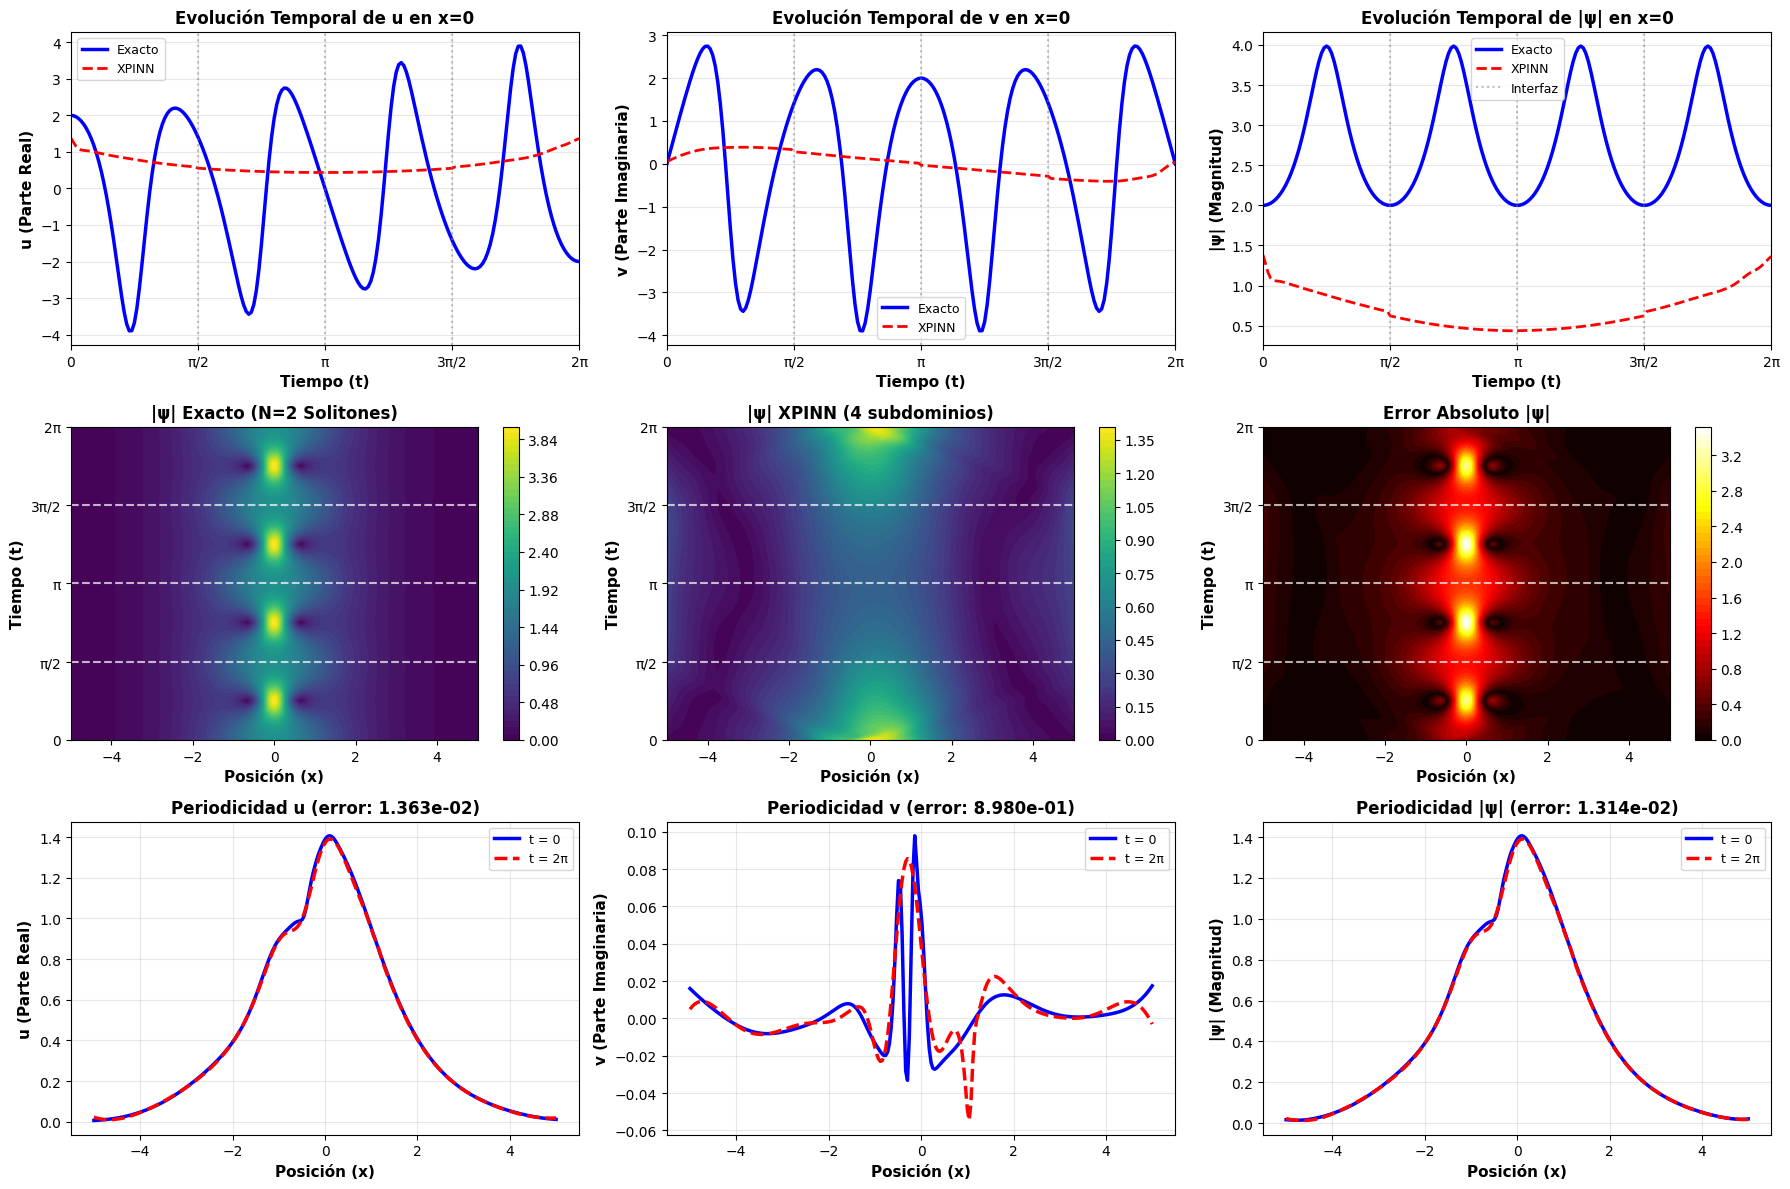

Gráfica guardada: NLS_XPINN_Results.png


In [12]:
# =====================================================================
# VISUALIZACIÓN DE RESULTADOS
# =====================================================================

fig = plt.figure(figsize=(18, 12))

# Punto central en x=0
central_idx = np.argmin(np.abs(x))

# -------- Fila 1: Evolución temporal en x=0 --------
ax1 = plt.subplot(3, 3, 1)
ax1.plot(t, Exact_u[central_idx, :], 'b-', linewidth=2.5, label='Exacto')
ax1.plot(t, U_pred[:, central_idx], 'r--', linewidth=2, label='XPINN')
for i in range(1, n_subdomains):
    ax1.axvline(x=t_interfaces[i], color='gray', linestyle=':', alpha=0.5)
ax1.set_xlabel('Tiempo (t)', fontsize=11, fontweight='bold')
ax1.set_ylabel('u (Parte Real)', fontsize=11, fontweight='bold')
ax1.set_title('Evolución Temporal de u en x=0', fontsize=12, fontweight='bold')
ax1.legend(frameon=True, fontsize=9)
ax1.grid(True, alpha=0.3)
ax1.set_xlim(0, 2*np.pi)
ax1.set_xticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi])
ax1.set_xticklabels(['0', 'π/2', 'π', '3π/2', '2π'])

ax2 = plt.subplot(3, 3, 2)
ax2.plot(t, Exact_v[central_idx, :], 'b-', linewidth=2.5, label='Exacto')
ax2.plot(t, V_pred[:, central_idx], 'r--', linewidth=2, label='XPINN')
for i in range(1, n_subdomains):
    ax2.axvline(x=t_interfaces[i], color='gray', linestyle=':', alpha=0.5)
ax2.set_xlabel('Tiempo (t)', fontsize=11, fontweight='bold')
ax2.set_ylabel('v (Parte Imaginaria)', fontsize=11, fontweight='bold')
ax2.set_title('Evolución Temporal de v en x=0', fontsize=12, fontweight='bold')
ax2.legend(frameon=True, fontsize=9)
ax2.grid(True, alpha=0.3)
ax2.set_xlim(0, 2*np.pi)
ax2.set_xticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi])
ax2.set_xticklabels(['0', 'π/2', 'π', '3π/2', '2π'])

ax3 = plt.subplot(3, 3, 3)
ax3.plot(t, Exact_h[central_idx, :], 'b-', linewidth=2.5, label='Exacto')
ax3.plot(t, H_pred[:, central_idx], 'r--', linewidth=2, label='XPINN')
for i in range(1, n_subdomains):
    ax3.axvline(x=t_interfaces[i], color='gray', linestyle=':', alpha=0.5, label='Interfaz' if i==1 else '')
ax3.set_xlabel('Tiempo (t)', fontsize=11, fontweight='bold')
ax3.set_ylabel('|ψ| (Magnitud)', fontsize=11, fontweight='bold')
ax3.set_title('Evolución Temporal de |ψ| en x=0', fontsize=12, fontweight='bold')
ax3.legend(frameon=True, fontsize=9)
ax3.grid(True, alpha=0.3)
ax3.set_xlim(0, 2*np.pi)
ax3.set_xticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi])
ax3.set_xticklabels(['0', 'π/2', 'π', '3π/2', '2π'])

# -------- Fila 2: Mapas de calor --------
ax4 = plt.subplot(3, 3, 4)
im1 = ax4.contourf(X_mesh, T_mesh, Exact_h.T, levels=50, cmap='viridis')
for i in range(1, n_subdomains):
    ax4.axhline(y=t_interfaces[i], color='white', linestyle='--', linewidth=1.5, alpha=0.7)
ax4.set_xlabel('Posición (x)', fontsize=11, fontweight='bold')
ax4.set_ylabel('Tiempo (t)', fontsize=11, fontweight='bold')
ax4.set_title('|ψ| Exacto (N=2 Solitones)', fontsize=12, fontweight='bold')
ax4.set_yticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi])
ax4.set_yticklabels(['0', 'π/2', 'π', '3π/2', '2π'])
plt.colorbar(im1, ax=ax4)

ax5 = plt.subplot(3, 3, 5)
im2 = ax5.contourf(X_mesh, T_mesh, H_pred, levels=50, cmap='viridis')
for i in range(1, n_subdomains):
    ax5.axhline(y=t_interfaces[i], color='white', linestyle='--', linewidth=1.5, alpha=0.7)
ax5.set_xlabel('Posición (x)', fontsize=11, fontweight='bold')
ax5.set_ylabel('Tiempo (t)', fontsize=11, fontweight='bold')
ax5.set_title(f'|ψ| XPINN ({n_subdomains} subdominios)', fontsize=12, fontweight='bold')
ax5.set_yticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi])
ax5.set_yticklabels(['0', 'π/2', 'π', '3π/2', '2π'])
plt.colorbar(im2, ax=ax5)

ax6 = plt.subplot(3, 3, 6)
error_map = np.abs(Exact_h.T - H_pred)
im3 = ax6.contourf(X_mesh, T_mesh, error_map, levels=50, cmap='hot')
for i in range(1, n_subdomains):
    ax6.axhline(y=t_interfaces[i], color='white', linestyle='--', linewidth=1.5, alpha=0.7)
ax6.set_xlabel('Posición (x)', fontsize=11, fontweight='bold')
ax6.set_ylabel('Tiempo (t)', fontsize=11, fontweight='bold')
ax6.set_title('Error Absoluto |ψ|', fontsize=12, fontweight='bold')
ax6.set_yticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi])
ax6.set_yticklabels(['0', 'π/2', 'π', '3π/2', '2π'])
plt.colorbar(im3, ax=ax6)

# -------- Fila 3: Periodicidad --------
ax7 = plt.subplot(3, 3, 7)
ax7.plot(x, u_t0_pred, 'b-', linewidth=2.5, label='t = 0')
ax7.plot(x, u_t2pi_pred, 'r--', linewidth=2.5, label='t = 2π')
ax7.set_xlabel('Posición (x)', fontsize=11, fontweight='bold')
ax7.set_ylabel('u (Parte Real)', fontsize=11, fontweight='bold')
ax7.set_title(f'Periodicidad u (error: {periodicity_error_u:.3e})', fontsize=12, fontweight='bold')
ax7.legend(frameon=True, fontsize=9)
ax7.grid(True, alpha=0.3)

ax8 = plt.subplot(3, 3, 8)
ax8.plot(x, v_t0_pred, 'b-', linewidth=2.5, label='t = 0')
ax8.plot(x, v_t2pi_pred, 'r--', linewidth=2.5, label='t = 2π')
ax8.set_xlabel('Posición (x)', fontsize=11, fontweight='bold')
ax8.set_ylabel('v (Parte Imaginaria)', fontsize=11, fontweight='bold')
ax8.set_title(f'Periodicidad v (error: {periodicity_error_v:.3e})', fontsize=12, fontweight='bold')
ax8.legend(frameon=True, fontsize=9)
ax8.grid(True, alpha=0.3)

ax9 = plt.subplot(3, 3, 9)
ax9.plot(x, h_t0_pred, 'b-', linewidth=2.5, label='t = 0')
ax9.plot(x, h_t2pi_pred, 'r--', linewidth=2.5, label='t = 2π')
ax9.set_xlabel('Posición (x)', fontsize=11, fontweight='bold')
ax9.set_ylabel('|ψ| (Magnitud)', fontsize=11, fontweight='bold')
ax9.set_title(f'Periodicidad |ψ| (error: {periodicity_error_h:.3e})', fontsize=12, fontweight='bold')
ax9.legend(frameon=True, fontsize=9)
ax9.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('NLS_XPINN_Results.png', dpi=300, bbox_inches='tight')
plt.show()

print("Gráfica guardada: NLS_XPINN_Results.png")

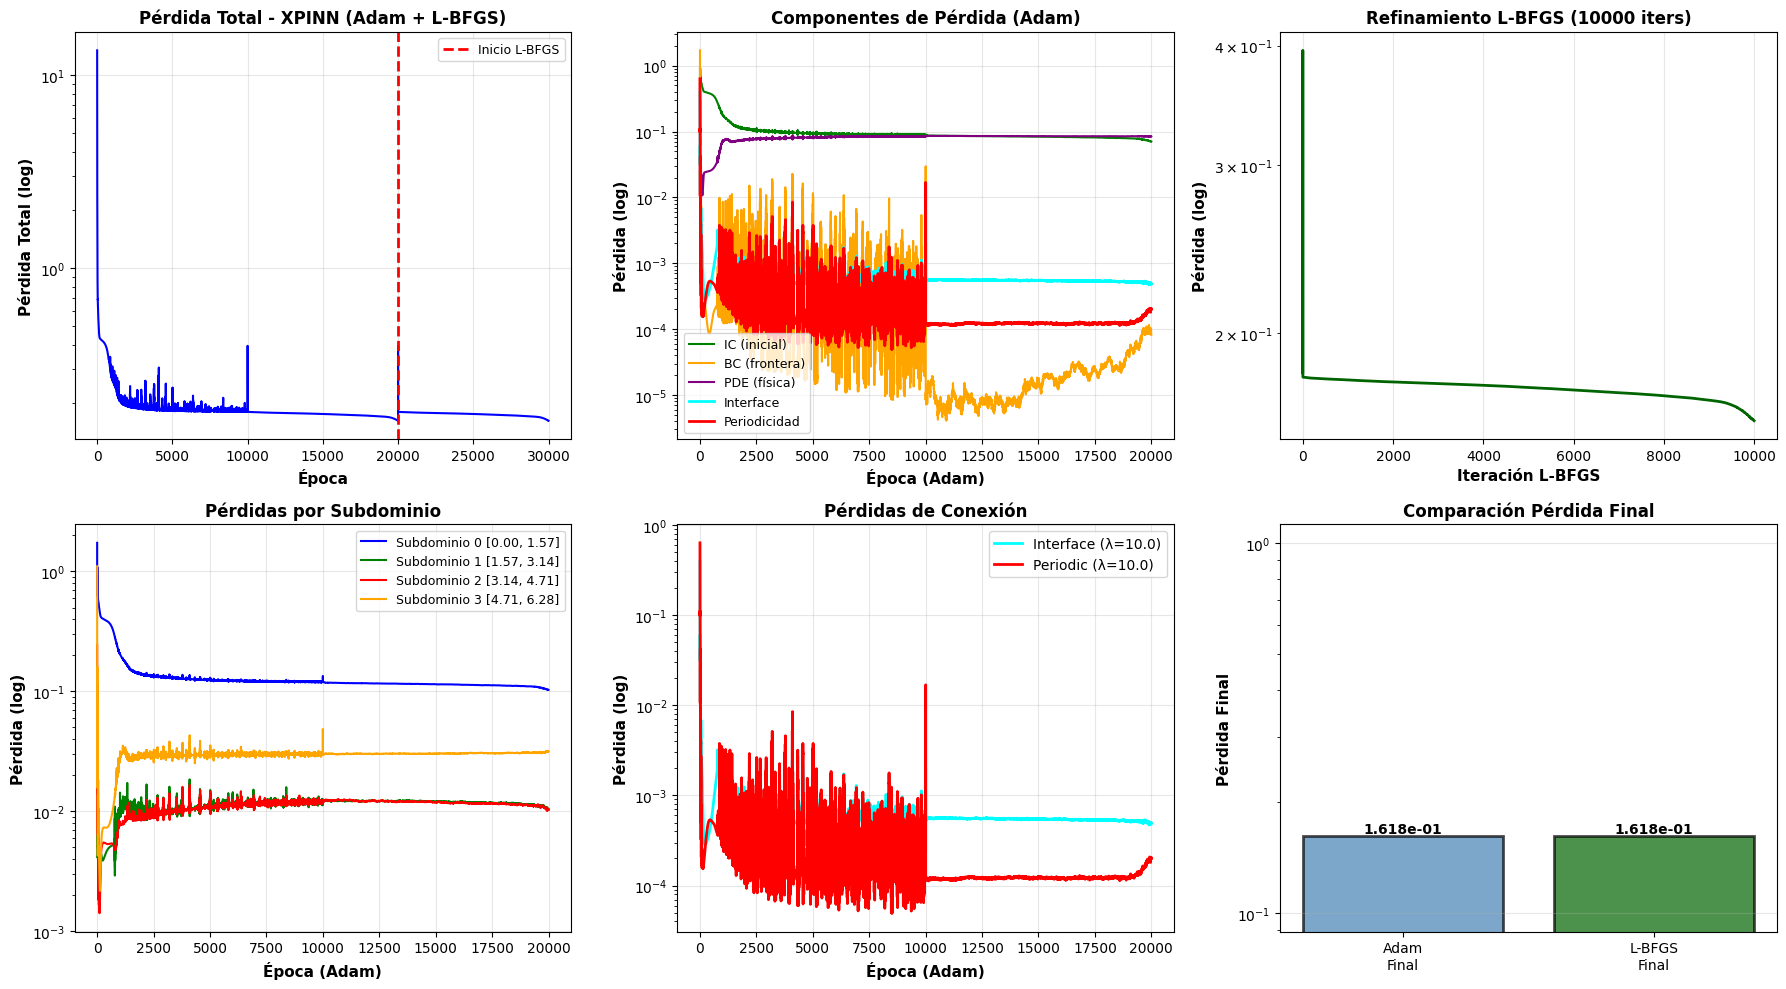

Gráfica guardada: NLS_XPINN_Training.png


In [13]:
# =====================================================================
# ANÁLISIS DE PÉRDIDAS
# =====================================================================

fig = plt.figure(figsize=(18, 10))

# Pérdida total combinada (Adam + L-BFGS)
ax1 = plt.subplot(2, 3, 1)
n_adam = len(model.loss_history['total'])
n_lbfgs = len(lbfgs_loss_history)
combined_epochs = list(range(n_adam)) + list(range(n_adam, n_adam + n_lbfgs))
combined_loss = model.loss_history['total'] + lbfgs_loss_history

ax1.plot(combined_epochs, combined_loss, 'b-', linewidth=1.5)
if n_lbfgs > 0:
    ax1.axvline(x=n_adam, color='red', linestyle='--', linewidth=2, label='Inicio L-BFGS')
    ax1.legend(fontsize=9)
ax1.set_yscale('log')
ax1.set_xlabel('Época', fontsize=11, fontweight='bold')
ax1.set_ylabel('Pérdida Total (log)', fontsize=11, fontweight='bold')
ax1.set_title('Pérdida Total - XPINN (Adam + L-BFGS)', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Componentes de pérdida (solo Adam)
ax2 = plt.subplot(2, 3, 2)
ax2.plot(model.loss_history['ic'], 'g-', linewidth=1.5, label='IC (inicial)')
ax2.plot(model.loss_history['bc'], 'orange', linewidth=1.5, label='BC (frontera)')
ax2.plot(model.loss_history['pde'], 'purple', linewidth=1.5, label='PDE (física)')
ax2.plot(model.loss_history['interface'], 'cyan', linewidth=2, label='Interface')
ax2.plot(model.loss_history['periodic'], 'r-', linewidth=2, label='Periodicidad')
ax2.set_yscale('log')
ax2.set_xlabel('Época (Adam)', fontsize=11, fontweight='bold')
ax2.set_ylabel('Pérdida (log)', fontsize=11, fontweight='bold')
ax2.set_title('Componentes de Pérdida (Adam)', fontsize=12, fontweight='bold')
ax2.legend(frameon=True, fontsize=9)
ax2.grid(True, alpha=0.3)

# L-BFGS detallado
ax3 = plt.subplot(2, 3, 3)
if len(lbfgs_loss_history) > 0:
    ax3.plot(lbfgs_loss_history, 'darkgreen', linewidth=2)
    ax3.set_yscale('log')
    ax3.set_xlabel('Iteración L-BFGS', fontsize=11, fontweight='bold')
    ax3.set_ylabel('Pérdida (log)', fontsize=11, fontweight='bold')
    ax3.set_title(f'Refinamiento L-BFGS ({len(lbfgs_loss_history)} iters)', fontsize=12, fontweight='bold')
    ax3.grid(True, alpha=0.3)
else:
    ax3.text(0.5, 0.5, 'L-BFGS no ejecutado', ha='center', va='center', fontsize=12)
    ax3.set_xticks([])
    ax3.set_yticks([])

# Pérdidas por subdominio
ax4 = plt.subplot(2, 3, 4)
n_subdominios = len(t_interfaces) - 1
colors = ['blue', 'green', 'red', 'orange', 'purple', 'cyan']
for i in range(n_subdominios):
    color = colors[i % len(colors)]
    ax4.plot(model.subdomain_losses[i], color=color, linewidth=1.5, 
             label=f'Subdominio {i} [{t_interfaces[i]:.2f}, {t_interfaces[i+1]:.2f}]')
ax4.set_yscale('log')
ax4.set_xlabel('Época (Adam)', fontsize=11, fontweight='bold')
ax4.set_ylabel('Pérdida (log)', fontsize=11, fontweight='bold')
ax4.set_title('Pérdidas por Subdominio', fontsize=12, fontweight='bold')
ax4.legend(frameon=True, fontsize=9)
ax4.grid(True, alpha=0.3)

# Pérdidas de interfaz y periodicidad
ax5 = plt.subplot(2, 3, 5)
ax5.plot(model.loss_history['interface'], 'cyan', linewidth=2, label=f'Interface (λ={lambda_interface})')
ax5.plot(model.loss_history['periodic'], 'r-', linewidth=2, label=f'Periodic (λ={lambda_periodic})')
ax5.set_yscale('log')
ax5.set_xlabel('Época (Adam)', fontsize=11, fontweight='bold')
ax5.set_ylabel('Pérdida (log)', fontsize=11, fontweight='bold')
ax5.set_title('Pérdidas de Conexión', fontsize=12, fontweight='bold')
ax5.legend(frameon=True, fontsize=10)
ax5.grid(True, alpha=0.3)

# Comparación Adam vs L-BFGS
ax6 = plt.subplot(2, 3, 6)
if len(lbfgs_loss_history) > 0:
    final_adam = model.loss_history['total'][-1]
    final_lbfgs = lbfgs_loss_history[-1]
    methods = ['Adam\nFinal', 'L-BFGS\nFinal']
    losses = [final_adam, final_lbfgs]
    colors_bar = ['steelblue', 'darkgreen']
    bars = ax6.bar(methods, losses, color=colors_bar, alpha=0.7, edgecolor='black', linewidth=2)
    ax6.set_ylabel('Pérdida Final', fontsize=11, fontweight='bold')
    ax6.set_title('Comparación Pérdida Final', fontsize=12, fontweight='bold')
    ax6.set_yscale('log')
    ax6.grid(True, alpha=0.3, axis='y')
    
    # Agregar valores en las barras
    for bar, loss in zip(bars, losses):
        height = bar.get_height()
        ax6.text(bar.get_x() + bar.get_width()/2., height,
                f'{loss:.3e}', ha='center', va='bottom', fontsize=10, fontweight='bold')
else:
    ax6.text(0.5, 0.5, 'No se ejecutó L-BFGS', ha='center', va='center', fontsize=12)
    ax6.set_xticks([])
    ax6.set_yticks([])

plt.tight_layout()
plt.savefig('NLS_XPINN_Training.png', dpi=300, bbox_inches='tight')
plt.show()

print("Gráfica guardada: NLS_XPINN_Training.png")

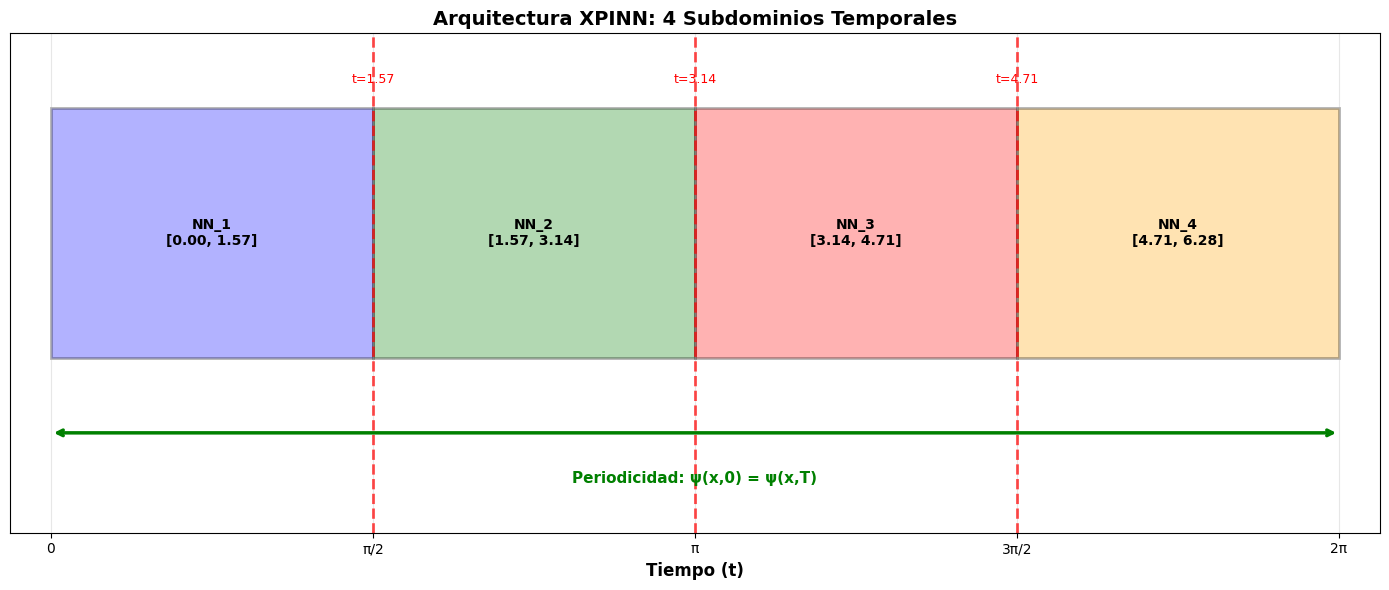

Gráfica guardada: NLS_XPINN_Architecture.png


In [14]:
# =====================================================================
# DIAGRAMA DE ARQUITECTURA XPINN
# =====================================================================

fig, ax = plt.subplots(1, 1, figsize=(14, 6))

# Dibujar subdominios
for i in range(n_subdominios):
    t_start = t_interfaces[i]
    t_end = t_interfaces[i+1]
    t_center = (t_start + t_end) / 2
    
    # Rectángulo para el subdominio
    rect = plt.Rectangle((t_start, 0), t_end - t_start, 1, 
                         facecolor=colors[i % len(colors)], 
                         edgecolor='black', linewidth=2, alpha=0.3)
    ax.add_patch(rect)
    
    # Texto
    ax.text(t_center, 0.5, f'NN_{i+1}\n[{t_start:.2f}, {t_end:.2f}]',
           horizontalalignment='center', verticalalignment='center',
           fontsize=10, fontweight='bold')
    
    # Interfaces
    if i < n_subdominios - 1:
        ax.axvline(x=t_end, color='red', linestyle='--', linewidth=2, alpha=0.7)
        ax.text(t_end, 1.1, f't={t_end:.2f}', 
               horizontalalignment='center', fontsize=9, color='red')

# Flecha de periodicidad
ax.annotate('', xy=(0, -0.3), xytext=(T_period, -0.3),
           arrowprops=dict(arrowstyle='<->', color='green', lw=2.5))
ax.text(T_period/2, -0.5, 'Periodicidad: ψ(x,0) = ψ(x,T)', 
       horizontalalignment='center', fontsize=11, color='green', fontweight='bold')

ax.set_xlim(-0.2, T_period + 0.2)
ax.set_ylim(-0.7, 1.3)
ax.set_xlabel('Tiempo (t)', fontsize=12, fontweight='bold')
ax.set_xticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi])
ax.set_xticklabels(['0', 'π/2', 'π', '3π/2', '2π'])
ax.set_yticks([])
ax.set_title(f'Arquitectura XPINN: {n_subdominios} Subdominios Temporales', 
            fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('NLS_XPINN_Architecture.png', dpi=300, bbox_inches='tight')
plt.show()

print("Gráfica guardada: NLS_XPINN_Architecture.png")

In [15]:
# =====================================================================
# GUARDAR RESULTADOS
# =====================================================================

# Guardar arrays
np.savez_compressed('NLS_XPINN_results.npz',
    x=x,
    t=t,
    X=X_mesh,
    T=T_mesh,
    Exact_u=Exact_u,
    Exact_v=Exact_v,
    Exact_h=Exact_h,
    U_pred=U_pred,
    V_pred=V_pred,
    H_pred=H_pred,
    error_u=error_u,
    error_v=error_v,
    error_h=error_h,
    periodicity_error_u=periodicity_error_u,
    periodicity_error_v=periodicity_error_v,
    periodicity_error_h=periodicity_error_h,
    t_interfaces=t_interfaces
)

# Guardar metadata
metadata = {
    'model_type': 'XPINN - Extended Physics-Informed Neural Networks with L-BFGS refinement',
    'equation': 'Nonlinear Schrödinger (NLS) N=2',
    'spatial_domain': [float(lb[0]), float(ub[0])],
    'temporal_domain': [float(lb[1]), float(ub[1])],
    'period': float(T_period),
    'n_subdomains': int(n_subdomains),
    't_interfaces': t_interfaces.tolist(),
    'architecture_per_subdomain': layers,
    'lambda_interface': float(lambda_interface),
    'lambda_periodic': float(lambda_periodic),
    'training_points': {
        'initial_condition': int(N0),
        'collocation_per_subdomain': int(N_f_per_subdomain),
        'total_collocation': int(n_subdominios * N_f_per_subdomain)
    },
    'optimization': {
        'adam_epochs': len(model.loss_history['total']),
        'adam_time_sec': float(elapsed_adam),
        'lbfgs_iterations': len(lbfgs_loss_history),
        'lbfgs_time_sec': float(elapsed_lbfgs),
        'total_time_sec': float(elapsed_total),
        'loss_adam_initial': float(model.loss_history['total'][0]),
        'loss_adam_final': float(model.loss_history['total'][-1]),
        'loss_lbfgs_final': float(lbfgs_loss_history[-1]) if len(lbfgs_loss_history) > 0 else None,
        'improvement_lbfgs': float(model.loss_history['total'][-1] - lbfgs_loss_history[-1]) if len(lbfgs_loss_history) > 0 else None
    },
    'errors': {
        'u_relative_L2': float(error_u),
        'v_relative_L2': float(error_v),
        'h_relative_L2': float(error_h),
        'periodicity_u': float(periodicity_error_u),
        'periodicity_v': float(periodicity_error_v),
        'periodicity_h': float(periodicity_error_h)
    },
    'device': str(device),
    'framework': 'PyTorch with XPINN decomposition',
    'method_explanation': 'Divide el dominio temporal en subdominios con redes independientes conectadas por condiciones de continuidad. Refinamiento final con L-BFGS sobre todos los parámetros.',
    'advantages': [
        'Especialización: cada red se enfoca en un tramo temporal',
        'Paralelización: las redes pueden entrenarse en paralelo',
        'Mejor convergencia: problemas más simples por subdominio',
        'Escalabilidad: fácil añadir más subdominios',
        'Refinamiento L-BFGS: optimización de segundo orden para mayor precisión'
    ]
}

with open('NLS_XPINN_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=4)

print(f"\n{'='*60}")
print(f"RESULTADOS GUARDADOS")
print(f"{'='*60}")
print(f"Arrays:   NLS_XPINN_results.npz")
print(f"Metadata: NLS_XPINN_metadata.json")
print(f"Imágenes:")
print(f"  - NLS_XPINN_Results.png")
print(f"  - NLS_XPINN_Training.png")
print(f"  - NLS_XPINN_Architecture.png")
print(f"{'='*60}\n")

print("\n✅ ¡XPINN completado con refinamiento L-BFGS!")
print(f"\nMétodo: División del dominio temporal en {n_subdominios} subdominios")
print(f"Cada subdominio tiene su propia red neuronal")
print(f"Conectados por condiciones de continuidad en interfaces")

print(f"\n📊 Optimización:")
print(f"  Adam:   {elapsed_adam:.2f}s ({len(model.loss_history['total'])} épocas)")
print(f"  L-BFGS: {elapsed_lbfgs:.2f}s ({len(lbfgs_loss_history)} iteraciones)")
print(f"  Total:  {elapsed_total:.2f}s")

if len(lbfgs_loss_history) > 0:
    print(f"\n🎯 Pérdidas:")
    print(f"  Adam final:   {model.loss_history['total'][-1]:.6e}")
    print(f"  L-BFGS final: {lbfgs_loss_history[-1]:.6e}")
    improvement = model.loss_history['total'][-1] - lbfgs_loss_history[-1]
    print(f"  Mejora:       {improvement:.6e} ({improvement/model.loss_history['total'][-1]*100:.2f}%)")

print(f"\n📉 Errores relativos L2:")
print(f"  u: {error_u:.6e}")
print(f"  v: {error_v:.6e}")
print(f"  |ψ|: {error_h:.6e}")

print(f"\n🔄 Errores de periodicidad:")
print(f"  u: {periodicity_error_u:.6e}")
print(f"  v: {periodicity_error_v:.6e}")
print(f"  |ψ|: {periodicity_error_h:.6e}")


RESULTADOS GUARDADOS
Arrays:   NLS_XPINN_results.npz
Metadata: NLS_XPINN_metadata.json
Imágenes:
  - NLS_XPINN_Results.png
  - NLS_XPINN_Training.png
  - NLS_XPINN_Architecture.png


✅ ¡XPINN completado con refinamiento L-BFGS!

Método: División del dominio temporal en 4 subdominios
Cada subdominio tiene su propia red neuronal
Conectados por condiciones de continuidad en interfaces

📊 Optimización:
  Adam:   624.19s (20000 épocas)
  L-BFGS: 837.32s (10000 iteraciones)
  Total:  1461.51s

🎯 Pérdidas:
  Adam final:   1.618494e-01
  L-BFGS final: 1.618494e-01
  Mejora:       0.000000e+00 (0.00%)

📉 Errores relativos L2:
  u: 1.143755e+00
  v: 1.022064e+00
  |ψ|: 6.586143e-01

🔄 Errores de periodicidad:
  u: 1.363482e-02
  v: 8.979652e-01
  |ψ|: 1.314018e-02


## 📝 Nota sobre L-BFGS en XPINN

### ¿Por qué XPINN requiere un enfoque especial para L-BFGS?

A diferencia de los métodos A y B que usan una sola red neuronal, **XPINN utiliza múltiples redes** (una por subdominio). Durante el entrenamiento con Adam:

- ✅ Cada subdominio tiene su **propio optimizador Adam**
- ✅ Los gradientes se calculan **independientemente** por subdominio
- ✅ Las redes se conectan mediante pérdidas de interfaz y periodicidad

### El Desafío con L-BFGS

**L-BFGS** es un optimizador de **segundo orden** que requiere:
- Acceso a **todos los parámetros simultáneamente**
- Construcción de la **matriz Hessiana aproximada** (historia de gradientes)
- Optimización **global** del problema completo

### Solución Implementada

1. **Fase 1 - Adam**: Entrenar con múltiples optimizadores (uno por subdominio)
   - Convergencia rápida inicial
   - Especialización temporal por red
   
2. **Fase 2 - L-BFGS**: Unificar todos los parámetros en un **solo optimizador L-BFGS**
   - `get_all_parameters()` recolecta parámetros de todas las redes
   - L-BFGS optimiza globalmente sobre el dominio completo
   - Refinamiento final de alta precisión

### Beneficio

- 🚀 **Adam**: Convergencia rápida inicial con especialización por subdominio
- 🎯 **L-BFGS**: Refinamiento de precisión con optimización de segundo orden

Esta estrategia **híbrida** combina lo mejor de ambos mundos: la especialización de XPINN con la precisión de L-BFGS.

### Comparación con Métodos A y B

| Aspecto | Método A/B | Método C (XPINN) |
|---------|-----------|------------------|
| **Redes** | 1 red única | 4 redes (1 por subdominio) |
| **Optimizadores Adam** | 1 optimizador | 4 optimizadores |
| **L-BFGS** | Directo desde Adam | Unificación necesaria |
| **Complejidad** | Simple | Mayor coordinación |
| **Ventaja** | Implementación directa | Mejor para problemas largos |